# Natural Language Processing

One element that all neural networks that process text have in common is an embedding layer which uses word embeddings to transform arrays or sequences of scalar values representing words into arrays of floating-point numbers called word vectors. These vectors encode information aboout the meaning of words and relationship between them. The output of an embedding layer can be the input to a classification layer or it can be input to other types of neural network layers to tease more meaning from it before subjecting it to further processing.

## Text Preparation

CountVectorizer class from Scikit-Learn transforms rows of text into rows of word counts.
1. removes punctuation and numbers
2. converts all characters to lower-case
3. (optional) removes stop words

Vectorization is performed differently. Instead of creating a table of word counts it creates a table of sequences containing tokens representing individual words. Keras provides the Tokenizer class which is an equivalent of CountVectorizer but for deep-learning.

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer

lines = [
    'The quick brown fox',
    'Jumps over $$$ the lazy brown dog',
    'Who jumps high into the blue sky after counting 123',
    'And quickly returns to earth'
]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

2026-01-11 16:15:40.293414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768144540.310987  849908 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768144540.316622  849908 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768144540.329753  849908 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768144540.329798  849908 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768144540.329800  849908 computation_placer.cc:177] computation placer alr

In [2]:
sequences

[[1, 4, 2, 5],
 [3, 6, 1, 7, 2, 8],
 [9, 3, 10, 11, 1, 12, 13, 14, 15, 16],
 [17, 18, 19, 20, 21]]

In [3]:
words = tokenizer.sequences_to_texts(sequences)

In [4]:
words

['the quick brown fox',
 'jumps over the lazy brown dog',
 'who jumps high into the blue sky after counting 123',
 'and quickly returns to earth']

Words are converted to lower case and symbols are removed but stop words and numbers are still there.

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/nb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

lines = [
    'The quick brown fox',
    'Jumps over $$$ the lazy brown dog',
    'Who jumps high into the blue sky after counting 123',
    'And quickly returns to earth'
]

def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
    
lines = list(map(remove_stop_words, lines))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [7]:
sequences

[[3, 1, 4], [2, 5, 1, 6], [2, 7, 8, 9, 10], [11, 12, 13]]

In [8]:
words = tokenizer.sequences_to_texts(sequences)
words

['quick brown fox',
 'jumps lazy brown dog',
 'jumps high blue sky counting',
 'quickly returns earth']

Now the numbers and stop words have been removed. The sequences vary in range but a neural network expects all sequences to be the same length. Keras pad_sequences function performs this by truncating sequences longer than the specified length and padding sequencse shorter than the specified length with 0s.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequences = pad_sequences(sequences, maxlen=4)

In [10]:
padded_sequences

array([[ 0,  3,  1,  4],
       [ 2,  5,  1,  6],
       [ 7,  8,  9, 10],
       [ 0, 11, 12, 13]], dtype=int32)

The text input to a neural network for predictions has to be tokenized and padded the same way as text input to the model for training. To avoid doing this manually you can include a TextVectorization layer in the model.

## Word Embeddings

Another important element is converting padded sequences of word tokens into arrays of word vectors which represent each word with an array vector of floating-point numbers rather than a single integer. Each word in the input text is represented by a vector in the embedding layer and as the network is trained vectors representint individual words are adjusted to reflect their relationship to one another. If you are building a sentiment analysis model words such as excellent and amazing have similar connotations and the vectors representation of those words in the embedding space should be close together. The keras Embedding class can do the word embedding and has 3 parameters:
1. The vocabulary size - number of words in the bocabulary built by the Tokenizer
2. The number of dimensions in the embedding space - usually a number from 32 to 512 the more dimensions the more fitting power but also increased training time, each word gets encoded in the embedding space as m dimensional vector.
3. The length of each padded sequence


The vectors that represent individual words in an embedding layer are learnied during training just as the weights connecting neurons in adjacent dense layers are learned. If there are not enough training samples you could initialize the embedding layer with pretrained word embeddings rather than rely on it to learn the word embeddings on its own.

## Text Classification

Sequences of tokenized text are input into the embedding layer, the output from the embedding layer is a 2D matrix of floating-point numbers measuring m by n where m is the number of dimensions in the embedding space and n is the sequence length, then the flatten layer flattens the 2D output into a 1D array suitable for input to a dense layer which classifies the values.

In [11]:
import pandas as pd

df = pd.read_csv('Data/ham-spam.csv')
df = df.sample(frac=1, random_state=0)
df.head()

,IsSpam,Text
993,1,utf date course utf diminish weight our table...
859,1,utf any drugs eur utf for dose have you ever ...
298,0,expert finderhttps expertfinder enron com
553,1,and courtiers ministerssubsegment founded res...
672,1,for our clients fargo dear customer have updat...


In [12]:
df = df.drop_duplicates()
df.groupby('IsSpam').describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        499    499  cinergy closingthe closing schedule for the sa...    1
1        500    500   offer variety different licenses and discount...    1

In [33]:
x = df['Text']
y = df['IsSpam']

max_words = 10000
max_length = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding

model = Sequential()
model.add(Embedding(max_words, 32, input_length=max_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=20)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6621 - loss: 0.6279 - val_accuracy: 0.8750 - val_loss: 0.3944
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9424 - loss: 0.1907 - val_accuracy: 0.9300 - val_loss: 0.1735
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9875 - loss: 0.0531 - val_accuracy: 0.9550 - val_loss: 0.1453
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9925 - loss: 0.0265 - val_accuracy: 0.9550 - val_loss: 0.1284
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9987 - loss: 0.0134 - val_accuracy: 0.9700 - val_loss: 0.1246


[]

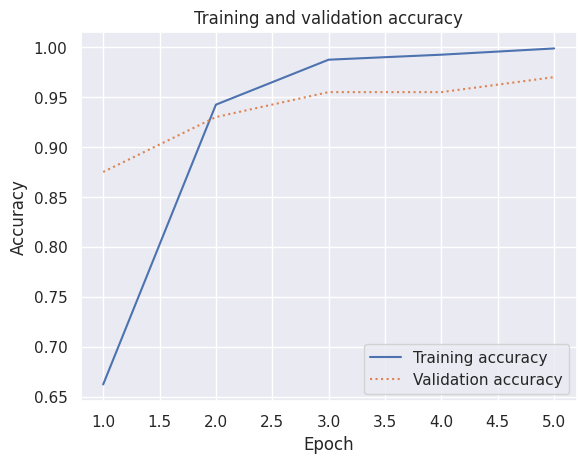

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [40]:
text = 'Can you attend a code review on Tuesday? Need to make sure the logic is rock solid.'

sequence = tokenizer.texts_to_sequences([text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


np.float32(0.5324409)

In [42]:
text = 'Why pay more for expensive meds when you can order them online and save $$$?'

sequence = tokenizer.texts_to_sequences([text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


np.float32(0.9713706)